In [32]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import networkx as nx
import matplotlib.pyplot as plt
import equinox as eqx
import jax

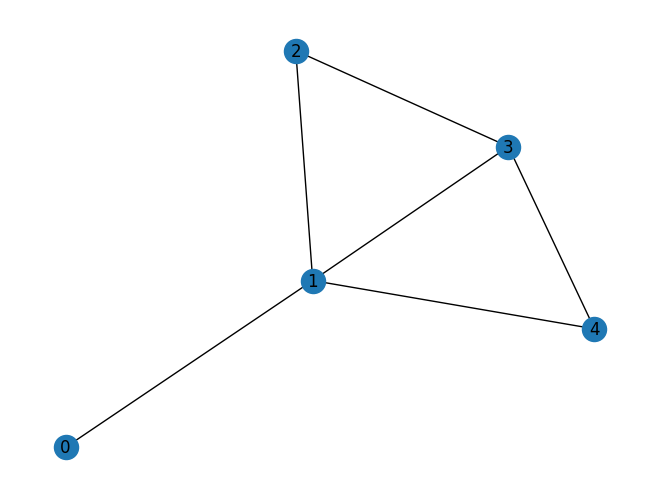

In [33]:
# Make a basic graph to test with
G = nx.Graph(gweight=jnp.array([0.0,3.0]))
G.add_node(0, nweight=jnp.array([3.0, 4.0]))
G.add_node(1, nweight=jnp.array([5.0, 6.0]))
G.add_node(2, nweight=jnp.array([5.0, 6.0]))
G.add_node(3, nweight=jnp.array([5.0, 6.0]))
G.add_node(4, nweight=jnp.array([5.0, 6.0]))
G.add_edge(0,1, eweight=jnp.array([1.0, 2.0]))
G.add_edge(1,2, eweight=jnp.array([2.0, 3.0]))
G.add_edge(2,3, eweight=jnp.array([2.0, 3.0]))
G.add_edge(3,4, eweight=jnp.array([3.0, 4.0]))
G.add_edge(4,1, eweight=jnp.array([2.0, 3.0]))
G.add_edge(3,1, eweight=jnp.array([1.0,2.0]))

nx.draw(G, with_labels=True)

In [34]:
# Function to get Nodes, Edges, Adjacency List, and Global tensors of 
# a networkx graph
def getNEALU(G):
    N = jnp.array([G.nodes[n]["nweight"] for n in G.nodes])
    E = jnp.array([G.edges[e]["eweight"] for e in G.edges])
    AL = jnp.array([e for e in G.edges])
    U = jnp.array([G.graph[p] for p in G.graph])
    return N.T, E.T, AL.T, U.T

N, E, AL, U = getNEALU(G)
print("Nodes (N):")
print(N)
print("Edges (E):")
print(E)
print("Adjacency List (AL):")
print(AL)
print("Global Props(U):")
print(U)

Nodes (N):
[[3. 5. 5. 5. 5.]
 [4. 6. 6. 6. 6.]]
Edges (E):
[[1. 2. 2. 1. 2. 3.]
 [2. 3. 3. 2. 3. 4.]]
Adjacency List (AL):
[[0 1 1 1 2 3]
 [1 2 4 3 3 4]]
Global Props(U):
[[0.]
 [3.]]


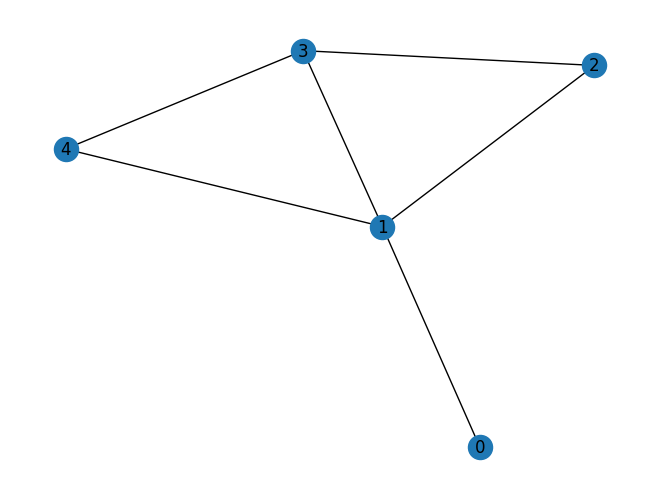

In [35]:
#Function to reconstruct a networkx graph from N,E, AL, U tensors
def reconstructNEALU(N, E, AL, U):
    G = nx.Graph(gweight=U[:,0])

    for i in range(N.shape[1]):
        G.add_node(i,nweight=N[:,i])
    G.nodes[1]
    for i in range(E.shape[1]):
        N1 = int(AL[0,i])
        N2 = int(AL[1,i])
        G.add_edge(N1, N2, eweight=E[:,i])

    return G

G2 = reconstructNEALU(N, E, AL, U)
nx.draw(G2, with_labels=True)

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'jaxlib.xla_extension.ArrayImpl'>


Array([[3.7249758, 6.2466426, 6.2466426, 6.2466426, 6.2466426],
       [3.687542 , 5.542799 , 5.542799 , 5.542799 , 5.542799 ]],      dtype=float32)

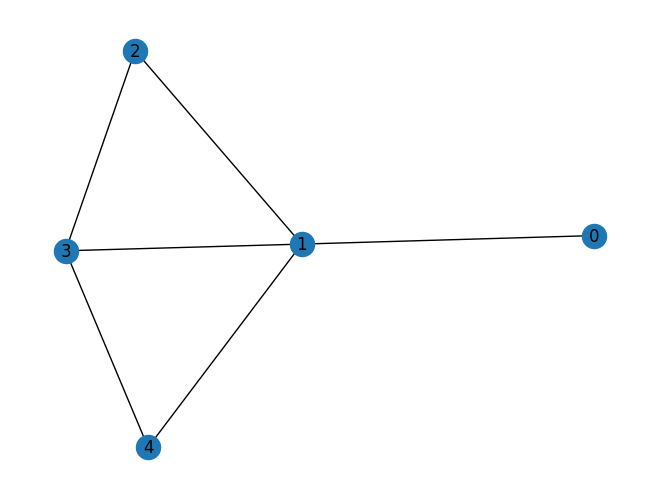

In [96]:
# Basic Linear module
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key):
        wkey, bkey = jax.random.split(key)
        self.weight = jax.random.normal(wkey, (out_size, in_size))
        self.bias = jax.random.normal(bkey, (out_size, 1))
    
    def __call__(self, x):
        #print(x.shape)
        return self.weight @ x + self.bias

class Block(eqx.Module):
    N_n: Linear
    E_n: Linear
    U_n: Linear

    def __init__(self,
                 N_in_size,
                 N_out_size,
                 N_key,
                 E_in_size,
                 E_out_size,
                 E_key,
                 U_in_size,
                 U_out_size,
                 U_key
                 ):
        self.N_n = Linear(N_in_size, N_out_size, N_key)
        self.E_n = Linear(E_in_size, E_out_size, E_key)
        self.U_n = Linear(U_in_size, U_out_size, U_key)
    
    def pool(self, N, AL):
        new_nodes = []
        for i in range(0, N.shape[1]):
            # Cursed way to get all adjacent
            column_indices_with_i = jnp.any(AL == i, axis=0)
            columns_with_i = AL[:,column_indices_with_i]
            non_i_indices = jnp.argmax(columns_with_i != i, axis=0)
            non_i_elements = columns_with_i[non_i_indices, jnp.arange(columns_with_i.shape[1])]

            summ = jnp.sum(N[:, non_i_elements], axis=1, keepdims=True)
            summ += N[:, i]
            new_nodes.append(summ)
        
        new_N = jnp.hstack(new_nodes)
        return new_N



    def __call__(self, N, E, U, AL):
        new_N = self.pool(N, AL)
        N_np1 = self.N_n(N)
        E_np1 = self.E_n(E)
        U_np1 = self.U_n(U)

        return N_np1, E_np1, U_np1

class GNN(eqx.Module):
    layers: list

    def __init__(self, key, nlayers=2):
        self.layers = []

        for i in range(nlayers):
            N_key, U_key, E_key = jax.random.split(key,3)
            new_block = Block(
                2,
                2,
                N_key,
                2,
                2,
                U_key,
                2,
                2,
                E_key
            )
            self.layers.append(new_block)

    def __call__(self, N, E, U, AL):
        for layer in self.layers:
            N, E, U = layer(N, E, U, AL)
        
        return N, E, U




batch_size = 1
N_in_size = 2
N_out_size = 2
E_in_size = 2
E_out_size = 2
U_in_size = 2
U_out_size = 2


# Using 1 key might be sus need to learn more.
key = jax.random.PRNGKey(1)

model = GNN(key, 2)

new_N, new_E, new_U = model(N, E, U, AL)

G_3 = reconstructNEALU(new_N, new_E, AL, new_U)
nx.draw(G_3, with_labels=True)

new_N

In [55]:
@jax.jit
@jax.grad
def loss(model, x, y):
    

SyntaxError: incomplete input (3998372901.py, line 2)

In [90]:
N

Array([[3., 5., 5., 5., 5.],
       [4., 6., 6., 6., 6.]], dtype=float32)